In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn import metrics
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

## Load the dataset

In [3]:
train_features = np.load('../Data/UTDMHAD_data/UTD_train_features.npy')
test_features = np.load('../Data/UTDMHAD_data/UTD_test_features.npy')
train_labels = np.load('../Data/UTDMHAD_data/UTD_train_labels.npy')
test_labels = np.load('../Data/UTDMHAD_data/UTD_test_labels.npy')

In [4]:
train_features.shape,  # 688   6 * 128

((688, 6, 128),)

#### Check the labels

In [5]:
train_labels[:100] # Label

array([ 7,  5, 11,  4, 12, 25, 25, 16,  1,  7, 15, 24,  7, 27, 16, 26, 18,
       10, 26, 24, 17, 21, 11, 14,  3,  5, 14,  9, 14, 12, 22, 15, 17,  5,
       14,  6, 17,  2, 15, 21, 17, 14, 14,  7, 19, 19, 27, 11, 25,  2,  7,
       14, 20, 15, 10, 18, 10, 16, 18, 14, 10, 22, 16, 25,  3, 26,  6, 27,
       13, 27,  5,  3, 23,  5,  2, 22,  3, 20, 26, 26, 16, 13,  8,  5,  6,
        1, 15,  7, 12, 15, 12,  5,  6,  1, 18, 11,  3, 19, 10, 14],
      dtype=int64)

#### Building loader
Images size = 6 * 128

In [6]:
tensor_train_features = torch.Tensor(train_features) # torch.Size([688, 6, 128])
tensor_train_labels = torch.Tensor(train_labels)
tensor_test_features = torch.Tensor(test_features) # torch.Size([173, 6, 128])
tensor_test_labels = torch.Tensor(test_labels)

# Add one dimension of channel
tensor_train_features = torch.unsqueeze(tensor_train_features, 1)# (torch.Size([688, 1, 6, 128]),)
tensor_test_features = torch.unsqueeze(tensor_test_features, 1)
train_dataset = TensorDataset(tensor_train_features, tensor_train_labels)
test_dataset = TensorDataset(tensor_test_features, tensor_test_labels)

In [7]:
tensor_train_features.shape, tensor_train_labels.shape, train_dataset

(torch.Size([688, 1, 6, 128]),
 torch.Size([688]),
 <torch.utils.data.dataset.TensorDataset at 0x236dfe6f190>)

In [8]:
# Hyper parameter 
BATCH_SIZE = 16# 32 # 
EPOCHES = 10

#### 创建数据集的可迭代对象 Iratable object with batch

In [9]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [10]:
len(train_loader), len(test_loader)

(43, 11)

In [11]:
images,labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([16, 1, 6, 128]), torch.Size([16]))

In [12]:
def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Recovery the image
    inp = np.clip(inp, 0, 1) # clip the pixel between 0 and 1
    plt.imshow(inp)
    #if titlle is not None:
        #plt.title(title)
   

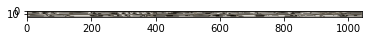

In [13]:
out = torchvision.utils.make_grid(images)
imshow(out)

#### LSTM

In [14]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # detach the hidden state to prevent exploding gradient
        out, (hn,cn) = self.lstm(x,( h0.detach(),c0.detach()))# detach 
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t     
        return out

In [15]:
input_dim = 128 # input dimension
hidden_dim = 1000 # hidden layers number
layer_dim = 1 
output_dim = 27 + 1 # output dimension

# initialize the model
model_lstm = LSTM_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_lstm.parameters(), lr = learning_rate)

When hidden_dim larger than 10 , gradient vanish

In [17]:
for i in range(len(list(model_lstm.parameters()))):
    print("parameters: %d" %(i+1))
    print(list(model_lstm.parameters())[i].size())

parameters: 1
torch.Size([4000, 128])
parameters: 2
torch.Size([4000, 1000])
parameters: 3
torch.Size([4000])
parameters: 4
torch.Size([4000])
parameters: 5
torch.Size([28, 1000])
parameters: 6
torch.Size([28])


In [18]:
sequence_dim = 6
lost_list_LSTM = []
accuracy_list = []
iteration_list = [] 
iter = 0

for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_lstm.train()
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        
        outputs = model_lstm(images)
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_lstm = criterion(outputs, labels)
        # backword
        loss_lstm.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 20 == 0:
            model_lstm.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_lstm(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            lost_list_LSTM.append(loss_lstm.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_lstm.item(), accuracy))
            
            


Iter:20,loss:2.2473058700561523,Accuracy:53.77907180786133
Iter:40,loss:1.8723894357681274,Accuracy:64.97093200683594
Iter:60,loss:1.4263367652893066,Accuracy:69.76744079589844
Iter:80,loss:1.5181937217712402,Accuracy:73.83721160888672
Iter:100,loss:1.4299960136413574,Accuracy:78.63372039794922
Iter:120,loss:1.7953914403915405,Accuracy:80.23255920410156
Iter:140,loss:0.7251518964767456,Accuracy:82.55813598632812
Iter:160,loss:0.972358226776123,Accuracy:83.5755844116211
Iter:180,loss:0.9932489991188049,Accuracy:87.20930480957031
Iter:200,loss:0.7114094495773315,Accuracy:87.35465240478516
Iter:220,loss:0.31384485960006714,Accuracy:91.86046600341797
Iter:240,loss:0.7228202819824219,Accuracy:91.27906799316406
Iter:260,loss:0.5286164283752441,Accuracy:94.04069519042969
Iter:280,loss:0.4461316168308258,Accuracy:93.60465240478516
Iter:300,loss:0.28846457600593567,Accuracy:94.47673797607422
Iter:320,loss:0.5152093172073364,Accuracy:92.00581359863281
Iter:340,loss:0.5684726238250732,Accuracy:94

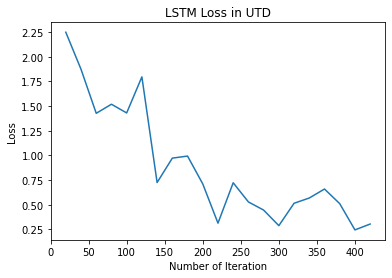

In [19]:
plt.plot(iteration_list,lost_list_LSTM)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("LSTM Loss in UTD")
plt.show()

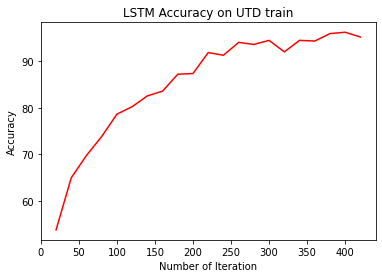

In [20]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("LSTM Accuracy on UTD train")
plt.show()

In [21]:
labels = []
predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_lstm(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()
    
    print('Test Accuracy of the basic LSTM model on the UTD test features: {} %'.format((correct / total) * 100))

Test Accuracy of the basic LSTM model on the UTD test features: 76.87861633300781 %


### Try RNN

In [22]:
# rnn
# num_feature = 6
# feature_width = 128
class RNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        #循环对象
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = "relu")
        
        #FC_layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()#.to(device) 
        # X.SIZE = batch SIZE
        
        # 分离隐藏状态，避免梯度爆炸
        out, hn = self.rnn(x, h0.detach())# detach 分离
        out = self.fc(out[:, -1, :])# -1 the last layer state at time t
            
        return out
        
        
    

Here the hidden_dim has number = 100 will have a better performances

In [23]:
input_dim = 128 # input dimension
hidden_dim = 100 # hidden layers number 
layer_dim = 2
output_dim = 27 + 1 # output dimension

# initialize the model
model_rnn = RNN_model(input_dim, hidden_dim, layer_dim, output_dim)
# device = torch.device('cuda:0' if torch.cuda.is_available() else  'cpu')

#model = model.to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model_rnn.parameters(), lr = learning_rate)

In [25]:
length = (len(list(model_rnn.parameters())))

In [26]:
for i in range(length):
    print("parameters: %d" %(i+1))
    print(list(model_rnn.parameters())[i].size())

parameters: 1
torch.Size([100, 128])
parameters: 2
torch.Size([100, 100])
parameters: 3
torch.Size([100])
parameters: 4
torch.Size([100])
parameters: 5
torch.Size([100, 100])
parameters: 6
torch.Size([100, 100])
parameters: 7
torch.Size([100])
parameters: 8
torch.Size([100])
parameters: 9
torch.Size([28, 100])
parameters: 10
torch.Size([28])


In [27]:
sequence_dim = 6
loss_list = []
accuracy_list = []
iteration_list = [] 
# 24576 = 32*1*6*128
iter =  0
for epoch in range(EPOCHES):
    for i, (images, labels) in enumerate(train_loader):
        model_rnn.train()
        # A batch of data with transfering the RNN input dimention 
        # 32*1*6*128
        images = images.view(-1, sequence_dim, input_dim).requires_grad_()#.to(device)
        labels = labels.to(torch.int64)
        #labels = labels.to(device)
        # gradient.zero
        optimizer.zero_grad()
        #forward pass
        output = model_rnn(images)

        
        # print(output.size(), labels.size(), "pass")
        # loss calc
        loss_rnn = criterion(output, labels)
        # backword
        loss_rnn.backward()
        # renew the parameter
        optimizer.step()
        
        iter += 1
        if iter % 10 == 0:
            model_rnn.eval()
            # accuracy
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(train_loader):
                    images = images.view(-1, sequence_dim, input_dim)#.to(device)
                    outputs = model_rnn(images)
                    #print(outputs.size())
                    
                    predict = torch.max(outputs.data, 1)[1]
                    total += labels.size(0)
                    correct += (predict == labels).sum()
            
            accuracy = correct / total * 100
            loss_list.append(loss_rnn.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # print the info
            print("Iter:{},loss:{},Accuracy:{}".format(iter, loss_rnn.item(), accuracy))
            
            
          
                    
        

Iter:10,loss:5.839676380157471,Accuracy:12.063953399658203
Iter:20,loss:3.6519417762756348,Accuracy:20.203489303588867
Iter:30,loss:2.760120153427124,Accuracy:21.6569766998291
Iter:40,loss:2.37896990776062,Accuracy:21.511627197265625
Iter:50,loss:3.231297731399536,Accuracy:23.98255729675293
Iter:60,loss:3.250673532485962,Accuracy:24.563953399658203
Iter:70,loss:2.629685401916504,Accuracy:27.03488540649414
Iter:80,loss:2.665022850036621,Accuracy:26.453489303588867
Iter:90,loss:2.7132298946380615,Accuracy:25.872093200683594
Iter:100,loss:2.4813554286956787,Accuracy:29.360464096069336
Iter:110,loss:2.3476316928863525,Accuracy:30.95930290222168
Iter:120,loss:2.2845585346221924,Accuracy:29.360464096069336
Iter:130,loss:2.618272066116333,Accuracy:33.430233001708984
Iter:140,loss:3.065587282180786,Accuracy:34.156978607177734
Iter:150,loss:2.5853817462921143,Accuracy:35.61046600341797
Iter:160,loss:2.053638219833374,Accuracy:35.319766998291016
Iter:170,loss:3.1067872047424316,Accuracy:34.30232

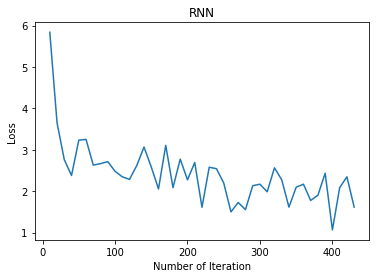

In [28]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("RNN")
plt.show()

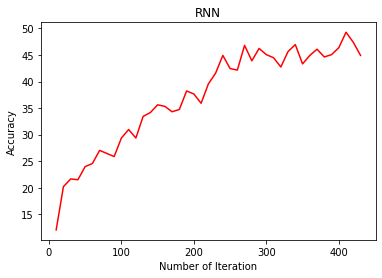

In [29]:
plt.plot(iteration_list,accuracy_list, color = "r")
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("RNN")
plt.show()

In [30]:
labels = []
predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.view(-1, sequence_dim, input_dim)#.to(device)
        outputs = model_rnn(images)
        #print(outputs.size())
                    
        predict = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predict == labels).sum()

    print('Test Accuracy of the basic RNN model on the UTD test features: {} %'.format((correct / total) * 100))

Test Accuracy of the basic RNN model on the UTD test features: 29.479768753051758 %
